In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Set date ranges:
# Start date
start = dt.datetime(2018,1,1)
# End date
end = dt.datetime(2020,6,30)

# Set symbol name
symbol_name = 'SP500'

In [3]:
# Dictionary of stock names & their corresponding symbols
symbols = {
    'SP500': '^GSPC',
    'Russell2000': '^RUT',
    'Apple': 'APPL',
    'Microsoft': 'MSFT'
}

# Import data using Pandas Datareader
df = web.DataReader(
        name = symbols[symbol_name], data_source = 'yahoo', 
        start = start, end = end
    )

# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))

High          Low         Open        Close      Volume  \
Date                                                                         
2018-01-02  2695.889893  2682.360107  2683.729980  2695.810059  3367250000   
2020-06-30  3111.510010  3047.830078  3050.199951  3100.290039  4696280000   

              Adj Close  
Date                     
2018-01-02  2695.810059  
2020-06-30  3100.290039  


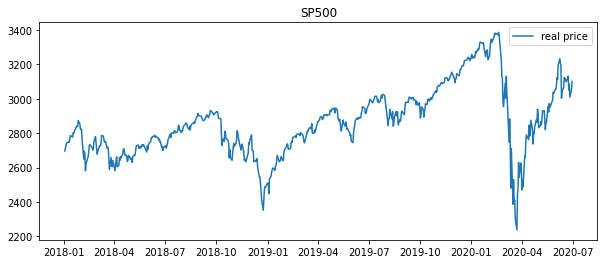

In [4]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend()
plt.show()

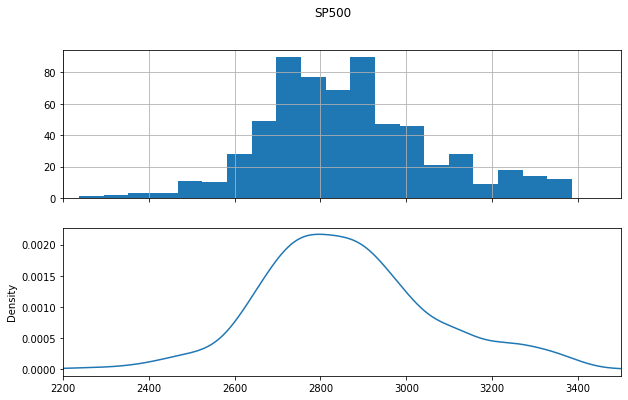

In [5]:
# Histogram/density plots of time series
fig, ax = plt.subplots(2, figsize=(10,6), sharex=True)
fig.suptitle(symbol_name)
df['Close'].hist(ax=ax[0], bins=20)
df['Close'].plot(kind='kde', ax=ax[1])
ax[0].set_xlim([2200,3500])
plt.show()

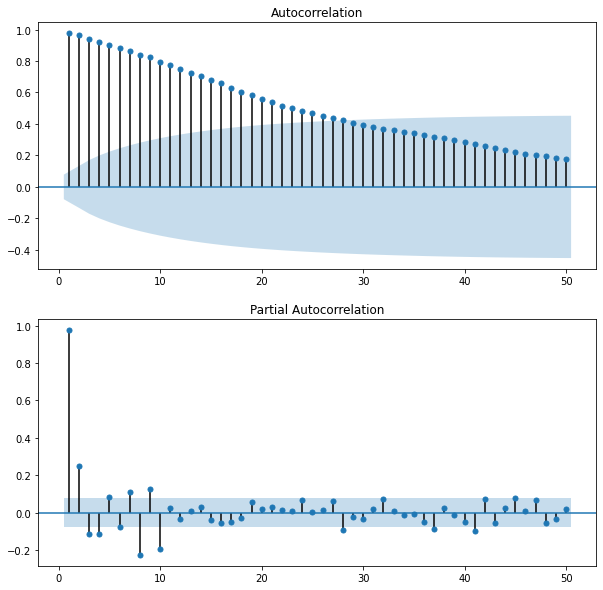

In [6]:
# ACF and PACF plots of time series
def plot_acf_pacf(df):
    # Create figure
    fig, ax = plt.subplots(2, figsize=(10,10))
    # Make ACF plot
    plot_acf(df, lags=50, zero=False, ax=ax[0])
    # Make PACF plot
    plot_pacf(df, lags=50, zero=False, ax=ax[1])
    # Show plots
    return plt.show()

plot_acf_pacf(df['Close'])

ADF Statistic: -7.016884
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


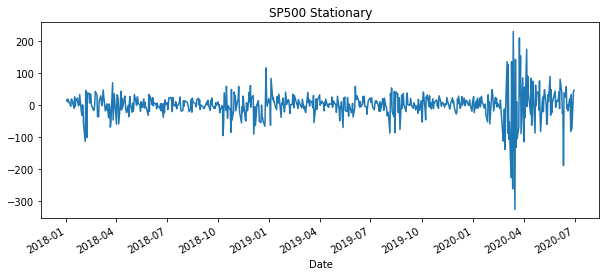

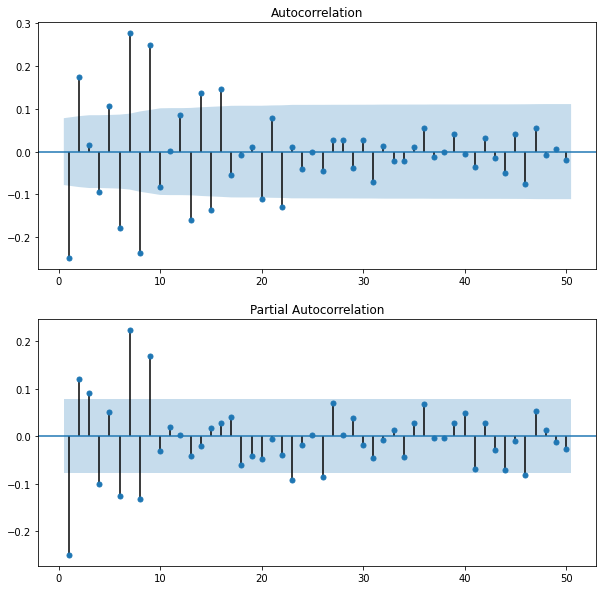

In [7]:
# Transform data from non-stationary to stationary
X = df.Close
# Method 1: difference data
stationary = X.diff(1)
# # Method 2: take the log
# stationary = np.log(X)
# # Method 3: take the square root 
# stationary = np.sqrt(X)
# # Method 4: take the proprtional change
# stationary = X.pct_change(1)
stationary.dropna(axis=0, inplace=True)

# check if stationary
result = adfuller(stationary)
# test statistic - more negative means more likely to be stationary
print('ADF Statistic: %f' % result[0])
# p-value - reject null hypothesis: non-stationary
print('p-value: %f' % result[1])
# critical test statistics - p-values: test statistic for null hypothesis
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot stationary dataset
stationary.plot(figsize=(10,4))
plt.title(symbol_name+' Stationary')
plt.show()

# plot ACF & PACF of stationary dataset
plot_acf_pacf(stationary)

In [9]:
# Searching over SARIMA model orders
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10,\
        seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        results = pm.auto_arima(
            self.df,
            start_p = self.start_p,
            start_q = self.start_q,
            max_p = self.max_p,
            max_q = self.max_q,
            seasonal = self.seasonal,
            # m = 14,
            # D = 1,
            # start_P = 1,
            # start_Q = 1,
            # max_P = 10,
            # max_Q = 10,
            information_criterion = self.information_criterion,
            trace = False,
            error_action = 'ignore',
            suppress_warnings=True,
            stepwise = True,
            scoring = 'mse'
        )
        return results

Train: 439, Test: 189


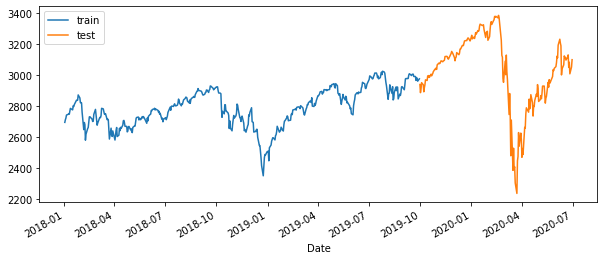

In [20]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

In [13]:
# Fit model with auto-arima
arima_model = Auto_Arima(train)
results = arima_model.arima_results()

In [14]:
# Check residuals
# Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
# Prob(JB) - p-value for null hypothesis that residuals are normal
print(results.summary())

SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  439
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2060.186
Date:                Fri, 10 Jul 2020   AIC                           4122.372
Time:                        20:26:44   BIC                           4126.455
Sample:                             0   HQIC                          4123.983
                                - 439                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       712.9215     31.330     22.755      0.000     651.516     774.327
Ljung-Box (Q):                       46.76   Jarque-Bera (JB):               174.76
Prob(Q):                              0.21   Prob(JB):                        

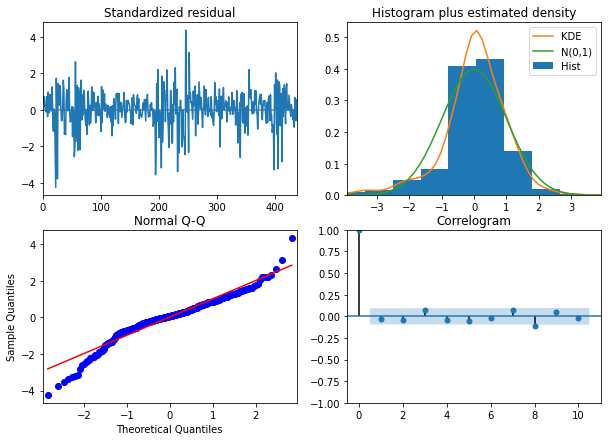

In [17]:
# Residuals are not correlated and are not normally distributed# Residuals are not correlated and are not normally distributed

# Plot diagnostics - check residuals:
# 1.Standardized residual - should be white noise
# 2.Histogram plus estimated density - expected normal distribution
# and kde overlap each other
# 3.Normal Q-Q - all points should lay on red line, except perhaps
# for some values at both ends
# 4.Correlogram - acf plot, 95% should not be significant
plot_diag = results.plot_diagnostics(figsize=(10,7))

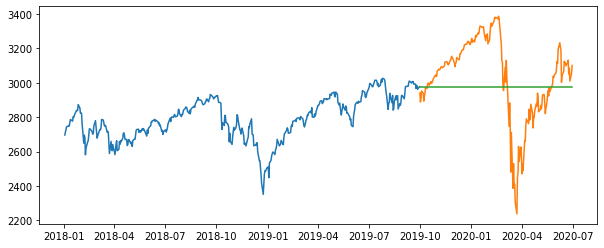

RMSE: 240.85


In [22]:
# Out-of-sample multi-step-forecast based on auto_arima results
predicted = results.predict(n_periods=len(test))
predicted = pd.DataFrame(predicted, index=test.index, columns=['predicted'])

def plot_train_test(train, test, df):
    # Plot the predictions for validation set
    plt.figure(figsize=(10,4))
    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(df, label='predicted')
    plt.show()

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, df))
    print(f'RMSE: {rmse:.2f}')

plot_train_test(train, test, predicted)

In [23]:
# ARIMA multi-step-forecast is pretty bad, so let's compare it with one-step-forecast
def one_step_forecast():
    predicted, conf_int = results.predict(n_periods=1, return_conf_int=True)
    return (
        predicted.tolist()[0],
        np.asarray(conf_int).tolist()[0])

predictions = []
confidence_intervals = []

for x in test:
    predicted, conf = one_step_forecast()
    predictions.append(predicted)
    confidence_intervals.append(conf)

    # Updates the existing model
    results.update(x)